In [1]:
import numpy as np
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools, random, copy, time, os
from collections import Counter
import pandas as pd
from scipy import sparse

In [2]:
#one hot encoding: Nxk, hard labels.
def one_hot_encoding(data_set_idx, labels_list,  K):
    onehot_encoded = np.zeros((len(data_set_idx), K))  
    for idx, value in enumerate(labels_list):
        one_hot = [0] * K
        one_hot[value] = 1
        onehot_encoded[idx] = one_hot
    return onehot_encoded.T

# Assignment 3

## 0.1 Read in the data and get it ready

In [3]:
#read ascii_names file:
with open('ascii_names.txt') as f:
    content = f.readlines()
content = [x.strip().rsplit(' ', 1) for x in content]

In [4]:
#names true labels: as many as names
ys = np.asarray([int(content[i][1])-1 for i in range(len(content))])

#true labels categories: e.g origin of the name, spanish english etc...
categ_labels = {}
with open('category_labels.txt') as f:
    read_categ_labels = f.readlines()
read_categ_labels = [x.strip().rsplit(' ', 1) for x in read_categ_labels]
for category in read_categ_labels:
    categ_labels[int(category[0])-1] = category[1]

In [5]:
#number of classes:
K = len(np.unique(ys))
#names and length:
names = [content[i][0].lower() for i in range(len(content))]
num_names = len(names)
#len of longer name.
names_length = [len(name) for name in names]
n_len = max(names_length)
#N = total number of names
N = len(names)
avg_names_length = sum(names_length)/N

In [6]:
f'number of classes: {len(categ_labels)} & number of observations~names: {N}.'

'number of classes: 18 & number of observations~names: 20050.'

In [7]:
#max name length:
print(f'longest name = {names[np.argmax([len(name) for name in names])]}')
print(f'longest name length= {n_len}.')

longest name = shirinskyshikhmatov
longest name length= 19.


In [8]:
#unique letters per name.
unique_letters_names = [list(set(names[i])) for i in range(len(names))]
unique_letters = list(set([item for sublist in unique_letters_names for item in sublist]))
unique_letters.sort()
#len of all unique characters "' abcdefghijklmnopqrstuvwxyz".
d = len(unique_letters)

In [9]:
#dict key: letter, value letter idx.
char_to_int = dict((letter, idx) for idx, letter in enumerate(unique_letters))
#dict key: letter idx, value letter.
int_to_char = dict((idx, letter) for idx, letter in enumerate(unique_letters))
#dict key: name idx, encoded letters.
name_encoded = dict((idx, [char_to_int[ch] for ch in name]) for idx, name in enumerate(names))

In [10]:
#X_vectorized dimension: d*lenxN
#x input: one hot encoding, each input will be a vector.
X_vectorized = np.zeros((d*n_len, num_names))
for key_name_idx, name_idx_encoding in name_encoded.items():
    name_matrix = np.zeros((d, n_len))
    for idx, value in enumerate(name_idx_encoding):
        letter = [0] * d
        letter[value] = 1
        name_matrix[:,idx] = letter
    X_vectorized[:,[key_name_idx]] = name_matrix.T.reshape(-1,1) #reshape for flatten

In [11]:
def vectorize_input(names_, d, n_len, char_to_int):
    #X_vectorized dimension: d*lenxN
    #x input: one hot encoding, each input will be a vector.
    names_ = [name.casefold() for name in names_]
    name_encoded = dict((idx, [char_to_int[ch] for ch in name]) for idx, name in enumerate(names_))
    num_names = len(names_)
    X_vectorized = np.zeros((d*n_len, num_names))
    for key_name_idx, name_idx_encoding in name_encoded.items():
        name_matrix = np.zeros((d, n_len))
        for idx, value in enumerate(name_idx_encoding):
            letter = [0] * d
            letter[value] = 1
            name_matrix[:,idx] = letter
        X_vectorized[:,[key_name_idx]] = name_matrix.T.reshape(-1,1) #reshape for flatten
    return X_vectorized

In [12]:
#X_matrix dimension: dxlenxN 
#x input: one hot encoding, each input will be a matrix dxlen.
X_matrix = np.zeros((d, n_len, num_names))
for key_name_idx, name_idx_encoding in name_encoded.items():
    name_matrix = np.zeros((d, n_len))
    for idx, value in enumerate(name_idx_encoding):
        letter = [0] * d
        letter[value] = 1
        name_matrix[:,idx] = letter
    X_matrix[:,:,key_name_idx] = name_matrix #reshape for flatten

In [13]:
#sanity check:
print(np.sum(X_matrix[:,:,0]))
print(np.sum(X_vectorized[:,[0]]))
f'name: {names[0]} & length: {len(names[0])}.'

6.0
6.0


'name: khoury & length: 6.'

In [14]:
#read Validation_Inds to get idx for the validation set:
with open('Validation_Inds.txt') as f:
    content_Validation_Inds = f.readlines()
content_Validation_idx = [(x.strip().split(' ')) for x in content_Validation_Inds]
content_Validation_idx = [int(x)-1 for x in content_Validation_idx[0]]

#get idx for the training set:
content_Training_idx = np.setdiff1d(np.arange(num_names), content_Validation_idx)

In [15]:
train_x = X_vectorized[:,content_Training_idx]
train_x_matrix = X_matrix[:,:,content_Training_idx]
train_y = np.asarray([ys[idx_] for idx_ in content_Training_idx])
train_Y = one_hot_encoding(content_Training_idx, train_y,  K)

val_x = X_vectorized[:,content_Validation_idx]
val_x_matrix = X_matrix[:,:,content_Validation_idx]
val_y = np.asarray([ys[idx_] for idx_ in content_Validation_idx])
val_Y = one_hot_encoding(content_Validation_idx, val_y,  K)


In [16]:
training_data_distrib = {x:round(list(train_y).count(x)/len(train_y),5)*100 for x in set(train_y)}
validation_data_distrib = {x:round(list(val_y).count(x)/len(val_y),4) for x in set(val_y)}

In [18]:
ordered_values = np.array(sorted(training_data_distrib.items(), key=lambda x: x[1], reverse=True))
ordered_keys = [list(categ_labels.values())[[int(i) for i in list(np.array(ordered_values)[:,0])][i]]
                                                for i in range (len(list(categ_labels.values())))]
print(pd.DataFrame(data=np.array(ordered_values)[:,1],
                   columns = ['Training Data Relative Frequency'], index=ordered_keys))

            Training Data Relative Frequency
Russian                               47.328
English                               18.456
Arabic                                10.031
Japanese                               4.935
German                                 3.586
Italian                                3.510
Czech                                  2.551
Spanish                                1.434
Dutch                                  1.429
French                                 1.328
Chinese                                1.283
Irish                                  1.101
Greek                                  0.955
Polish                                 0.631
Scottish                               0.434
Korean                                 0.404
Portuguese                             0.303
Vietnamese                             0.298


In [19]:
#sanity check:
train_y == np.argmax(train_Y,axis=0)

array([ True,  True,  True, ...,  True,  True,  True])

In [20]:
data = {'training': {'X':train_x,  'y': train_y, 'Y':train_Y },
        'validation': {'X':val_x, 'y': val_y, 'Y': val_Y  }}

# 0.2 Set hyper-parameters & initialize the ConvNet's parameters

In [21]:
class ConvNet:
    def __init__(self, data, model_param, weights_init):
        self.F = {}
        for i in range(len(weights_init['F'])):   
            self.F[i] = np.random.normal(loc=0.0, scale=weights_init['scale'][i], size=weights_init['F'][i])
        self.W = np.random.normal(loc=0.0, scale=weights_init['scale']['W'], size=weights_init['W'])
        
        self.model_param = model_param
        self.data = data

In [22]:
def set_weights_parameters(avg_names_length = avg_names_length,
                           n_1=5, k_1=5, n_len=n_len, n_2=5, k_2=5, 
                           eta=0.001, rho=.9, batch_size=100, 
                           epochs=10, n_updates=500): 
    
    """
    n_1: number of filters first layer.
    k_1: width of the filter first layer.
    n_len: len of longer name max(names_length).
    n_2: number of filters second layer.
    k_2: width of the filter second layer.
    """
    #1 filter: number and width of filters first layer:
    #filter size = dxk_1 = 28*5
    n_len_1 = n_len - k_1 + 1
    sig_1 = np.sqrt(2. / avg_names_length) #He initialization 
    
    #2 filter: number and width of filters second layer:
    #filter size = n_1*k_2 = 5*5
    n_len_2 = n_len_1-k_2 + 1
    sig_2 = np.sqrt(2. / n_1 * k_2) #He initialization

    #Weight matrix for fully connected layer:
    f_size = n_2 * n_len_2
    sig_3 = np.sqrt(2. / f_size) #He initialization

    F = {}
    weights_init = {'F' :{0: [d, k_1, n_1], 1: [n_1, k_2, n_2] },
                    'W':[K, f_size],
                   'scale': {0:sig_1, 1:sig_2, 'W':sig_3 }}

    model_param = {'eta': eta, #learning rate
                   'rho': rho, #momentum
                   'batch_size': batch_size,
                   'epochs': epochs,
                   'n_updates': n_updates}
    return weights_init, model_param

# 0.3 Construct the convolutional matrices

In [23]:
def build_matrix_from_filters(filters_array, nb_columns_inputs):
    """
    :param filters_array: filter
    """
    
    nb_rows, filter_width, nb_filters = filters_array.shape
    nb_columns_after_conv = nb_columns_inputs - filter_width + 1
    
    # as numpy.reshape stacks rows by rows from left to right, need to transpose to stack columns by columns
    # e.g if the filter dimenson = 28x5, and we have 5 filters we end up with 5x140, one vector per filter.
    reshaped_filters = filters_array.transpose().reshape((nb_filters, -1))
    #e.g if the filter dimension = 28x5 the flattened filter will be 140
    flattened_filter_size = reshaped_filters.shape[1]
    
    # we fill in the conv_filter matrix by stacking reshaped_filters in the right place:
    #the nb_columns_after_conv will be the number of times we perform the convolutional operation
    #in this case the filter has as many rows as the input so it makes it easier as we only have
    #to make it fit "nb_columns_after_conv" with a stride of 1.
    #e.g if the image is 28x19 and the filter is 28x5 the nb_columns_after_conv will be 15, as we 
    #will perform the operation 15 times.
    # we will fill the matrix by number of filters in this case 5 by 5 so we will perform the operation
    #15 times = which equals 75 rows.
    
    #we will stack results in convultion_matrix_from_filters with 
    #dimension 75 x 28*19 = 75 x (vectorized input = 532 or =>
    #((nb_input_columns - nb_filters)x nb_input_rows) + (filter_rows x filter_columsd) = (19-5)*28 + 140= 532)
    #as we use a stride of 1 every 5(filters) rows we will move 140 positions as this is the filter dimension
    convultion_matrix_from_filters = np.zeros((nb_columns_after_conv * nb_filters, nb_columns_inputs * nb_rows))
    
    for convolution_nb in range(nb_columns_after_conv):
        convultion_matrix_from_filters[
            # stacks 'convolution_nb' conv for each filter
            convolution_nb * nb_filters: (convolution_nb + 1) * nb_filters,
            convolution_nb * nb_rows: convolution_nb * nb_rows + flattened_filter_size
        ] = reshaped_filters
    return convultion_matrix_from_filters

In [24]:
def build_convolution_matrix_from_inputs(vectorized_input, d, k, nf):
    #we need to stack column by column. vectorized_input.shape = (d*k , 1)
#     vectorized_input = vectorized_input.T.reshape((-1,1))
    flattened_filter_size = d * k
    # n_len, vectorized_input.shape = (n_columns * d, 1)
    nb_columns = int(vectorized_input.shape[0] / d)  
    convolutions_number = nb_columns - k + 1
    #e.g 5 filters, 15 convolutions, filter column_n = k = 5, filter row_n = 28 = d
    #matrix_MX.shape = (15*5, 5*28*5) = (75, 140*5)
    #15 convolutions per filter(5), by vectorized filter(5*28) by filter (5)
    matrix_MX = np.zeros((nf * convolutions_number, k * nf * d))
    
    #this gives the different slices of vectorized input by convolution (15). 
    #each element should be then 5x28 (filter column_n x filter row_n)
    #e.g: [0:140], [28:168], [56:196], [84:224], [112:256], ...., [392:532]
    inputs_slices_for_convolution = [
        vectorized_input[d * conv_nb: d * conv_nb + flattened_filter_size]
        for conv_nb in range(convolutions_number)
    ]
    
    for full_matrix_row in range(matrix_MX.shape[0]): #matrix_MX.shape[0] = n_filters * n_convolutions
        # number in matrix_MX indices we are looking at.
        # filter_nb is in [0, 1, 2, ..., nf - 1], it translates the filter
        filter_nb = full_matrix_row % nf  
        
        # this will give us the vectorized slice vec(X:i,i+k) to put in the matrix, as
        # matrix_MX.shape[0] = convolutions_number * nf and there are convolutions_number
        # vectorized slices.
        #e.g full_matrix_row (0,...,4 // nf )= 0, (5,...,9 // nf )=1, ... , (70,...,74 // nf )=15
        vectorized_slice_to_put = inputs_slices_for_convolution[full_matrix_row // nf]
        
        matrix_MX[full_matrix_row, filter_nb * flattened_filter_size: (filter_nb + 1) * flattened_filter_size] = (
            vectorized_slice_to_put.reshape(-1)
        )
    return matrix_MX

In [25]:
weights_init, model_param = set_weights_parameters(n_1=5, k_1=5, n_len=max(names_length),
                                                   n_2=5, k_2=5, eta=0.001, rho=.9, 
                                                   batch_size=100,epochs=10, n_updates=500)

In [26]:
network=ConvNet(data, model_param,weights_init)

In [27]:
#MX returns matrix based on the entries in the input vector.
x_input = train_x[:,:1]
d, k, nf = network.F[0].shape
#n_column: number of columns of the input. e.g input size = 28x19, n_column=19
n_column = x_input.shape[0]//d 
flattened_filter_size = d * k

In [28]:
MF_layer_1 = build_matrix_from_filters(network.F[0], n_column)
MX_layer_1 = build_convolution_matrix_from_inputs(x_input, d, k, nf)

In [29]:
# checking that the first two rows of mat_MX have the same thing inside, for the part where it's equal
np.mean(MX_layer_1[0, : -flattened_filter_size] == MX_layer_1[1, flattened_filter_size:])

1.0

In [30]:
s1=np.dot(MX_layer_1, network.F[0].T.reshape(-1,1))
s2=np.dot(MF_layer_1,  train_x[:,:1])
print(np.sum(s1-s2))

0.0


# 0.4 Implement the forward & backward pass of back-prop

In [31]:
def ComputeLoss(Ys_batch, P_batch):
    n = Ys_batch.shape[1]
    prediction_labels = np.sum(np.multiply(Ys_batch, P_batch), axis=0)
    return -np.sum(np.log(prediction_labels)) / n

In [32]:
def ForwardPass(network, X_batch, sparse_input_matrix_filters):
    """
    X_batch has already been flattened column wise (first column, then second and so on...)
    """
    vectorized_batch_inputs = dict()
    filter_convolution_matrices = dict()
    nb_layers = len(network.F)
    
    # first conv layer
    n_len = X_batch.shape[0] // network.F[0].shape[0]
    filter_convolution_matrices[0] = sparse_input_matrix_filters
#     filter_convolution_matrices[0] = build_matrix_from_filters(network.F[0], n_len)
#     vectorized_first_convolution_array = np.maximum(0., np.matmul(filter_convolution_matrices[0], X_batch))
    vectorized_first_convolution_array = np.maximum(0., sparse_input_matrix_filters.dot(X_batch))
    vectorized_batch_inputs[0] = vectorized_first_convolution_array
    
    # second conv layer
    n_len_1 = vectorized_first_convolution_array.shape[0] // network.F[0].shape[2]
    filter_convolution_matrices[1] = build_matrix_from_filters(network.F[1], n_len_1)
    vectorized_second_convolution_array = np.maximum(
        0., np.matmul(filter_convolution_matrices[1], vectorized_first_convolution_array)
    )
    vectorized_batch_inputs[1] = vectorized_second_convolution_array
    
    # last NN layer
    s_batch = np.matmul(network.W, vectorized_second_convolution_array)
    p_batch = softmax(s_batch, axis=0)
    
    p_argmax = np.argmax(p_batch, axis=0)
    
    return vectorized_batch_inputs, p_batch, p_argmax, filter_convolution_matrices

In [33]:
def BackwardPass(network, X_batch, Ys_batch, sparse_input_matrix_filters):
    analytical_gradients = {}
    analytical_gradients['W'] = np.zeros_like(network.W)
    analytical_gradients['F'] = {i : np.zeros_like(network.F[i]).reshape(-1) for i in range(len(network.F))}

    n_layers = len(network.F)
    X, P_batch, P_argmax, MF_matrix = ForwardPass(network, X_batch, sparse_input_matrix_filters)
    
    loss = ComputeLoss(Ys_batch, P_batch)
    G_batch = -(Ys_batch - P_batch)

    n = X_batch.shape[1]
    analytical_gradients['W'] = np.dot(G_batch, X[n_layers - 1].T) / n
    
    # propagate the gradients through the fully connected layer and second RELU function
    G_batch = np.dot(network.W.T, G_batch)
    ind_2 = (X[n_layers - 1] > 0).astype(np.float64)
    # element by element multiplication
    G_batch = np.multiply(G_batch, ind_2)
    
    # compute the gradient w.r.t. the second layer convolutional filters for j = 1,...,n
    d, k, nf = network.F[n_layers-1].shape
    for j in range(n):
        g_j = G_batch[:, j]
        x_j = X[0][:, j]
        MX = build_convolution_matrix_from_inputs(x_j, d, k, nf)
        v = np.dot(g_j.T, MX)
        analytical_gradients['F'][n_layers - 1] += (1 / n) * v
    analytical_gradients['F'][n_layers - 1] = analytical_gradients['F'][n_layers - 1].reshape((nf, k, d)).T
    
    # propagate the gradient to the previous layer through the second convolutional 
    # layer and first RELU operation
    G_batch = np.dot(MF_matrix[n_layers-1].T, G_batch)
    ind_1 = (X[0] > 0).astype(np.float64)
    # element by element multiplication
    G_batch = np.multiply(G_batch, ind_1)
    
    # compute the gradient w.r.t. the first layer convolutional filters for j = 1,...,n
    d, k, nf = network.F[0].shape
    for j in range(n):
        g_j = G_batch[:, j]
        x_j = X_batch[:, j]
        MX = build_convolution_matrix_from_inputs(x_j, d, k, nf)
        v = np.dot(g_j.T, MX)
        analytical_gradients['F'][0] += (1 / n) * v
    analytical_gradients['F'][0] = analytical_gradients['F'][0].reshape((nf, k, d)).T

    return loss, P_argmax, analytical_gradients

In [34]:
def numericalGradients(network, X_batch, Ys_batch, h=1e-4):
    h = np.float64(h)
    numerical_gradients = {}
    numerical_gradients['W'] = np.zeros_like(network.W)
    numerical_gradients['F'] = {i : np.zeros_like(network.F[i]) for i in range(len(network.F))}

    #numerical gradients W
    for i in range(network.W.shape[0]):
        for j in range(network.W.shape[1]):
            initial_weight_value = copy.copy(network.W[i][j])
            network.W[i][j] = initial_weight_value + h
            _, P_batch, _, _ = ForwardPass(network, X_batch)
            l2 = ComputeLoss(Ys_batch, P_batch)

            # as I have previously modified the weights(+h) I need to substract twice - h
            network.W[i][j] = initial_weight_value - h
            _, P_batch, _, _ = ForwardPass(network, X_batch)
            l1 = ComputeLoss(Ys_batch, P_batch)

            #initial weights
            network.W[i][j] = initial_weight_value
            numerical_gradients['W'][i][j] = (l2-l1) / (2*h)

    #numerical gradients F
    for key, value in numerical_gradients['F'].items():
        for i in range(numerical_gradients['F'][key].shape[0]):
            for j in range(numerical_gradients['F'][key].shape[1]):
                for k in range(numerical_gradients['F'][key].shape[2]):
                # + h, I could have deep copied
                    initial_weight_value = copy.copy(network.F[key][i][j][k])
                    network.F[key][i][j][k] = initial_weight_value + h
                    _, P_batch, _, _ = ForwardPass(network, X_batch)
                    l2 = ComputeLoss(Ys_batch, P_batch)

                    # as I have previously modified the weights(+h) I need to substract twice - h
                    network.F[key][i][j][k] = initial_weight_value - h
                    _, P_batch, _, _ = ForwardPass(network, X_batch)
                    l1 = ComputeLoss(Ys_batch, P_batch)

                    #initial weights
                    network.F[key][i][j][k] = initial_weight_value
                    numerical_gradients['F'][key][i][j][k] = (l2-l1) / (2*h)
    
    return numerical_gradients

In [35]:
def VerifyGradients(network, analitical_gradients, numerical_gradients):    
    eps = 1e-30
    max_relative_error = {}
    absolute_v = np.maximum(eps, np.absolute(analitical_gradients['W']) + np.absolute(numerical_gradients['W']))
    max_relative_error['W']= np.amax(np.absolute(analitical_gradients['W'] - numerical_gradients['W'])/absolute_v)

    max_relative_error['F'] = {i : None for i in range(len(analitical_gradients['F']))}
    for i in range(len(analitical_gradients['F'])):
        absolute_v = np.maximum(
            eps, np.absolute(analitical_gradients['F'][i]) + np.absolute(numerical_gradients['F'][i])
        )
        max_relative_error['F'][i]= np.amax(
            np.absolute(analitical_gradients['F'][i]-numerical_gradients['F'][i]) / absolute_v)
    print(max_relative_error)


In [36]:
weights_init, model_param = set_weights_parameters(n_1=5, k_1=5, n_len=max(names_length),
                                                   n_2=5, k_2=5, eta=0.001, rho=.9, 
                                                   batch_size=100,epochs=10, n_updates=500)

In [37]:
network=ConvNet(data, model_param,weights_init)

In [38]:
#mini batch of n = 2
X_batch = train_x[: , :1]
Ys_batch = train_Y[: , :1]

In [39]:
for _ in range(5):
    VerifyGradients(network, analytical_gradients, numerical_gradients)

{'W': 6.880386643931729e-06, 'F': {0: 1.9324889324758395e-08, 1: 2.509727069019083e-07}}
{'W': 6.880386643931729e-06, 'F': {0: 1.9324889324758395e-08, 1: 2.509727069019083e-07}}
{'W': 6.880386643931729e-06, 'F': {0: 1.9324889324758395e-08, 1: 2.509727069019083e-07}}
{'W': 6.880386643931729e-06, 'F': {0: 1.9324889324758395e-08, 1: 2.509727069019083e-07}}
{'W': 6.880386643931729e-06, 'F': {0: 1.9324889324758395e-08, 1: 2.509727069019083e-07}}


In [40]:
def createBatches(network, X, Y, shuffle_data=False):
    n_batch = network.model_param['batch_size']
    Npts = X.shape[1]
    Xbatch = np.zeros((X.shape[0], n_batch, Npts // n_batch))
    Ybatch = np.zeros((Y.shape[0], n_batch, Npts // n_batch))
    
    if shuffle_data:
        sel = np.random.choice(X.shape[1], size=X.shape[1], replace=False)
        X = X[:,sel]
        Y = Y[:,sel]
    #e.g if the batch size is 100, and the total number of examples is 19798
    # we will end up with 197 batches each of 100 observations leaving 98 observations out.
    for j in range(Npts // n_batch):
        j_start = j * n_batch
        j_end = (j + 1) * n_batch
        Xbatch[:,:,j] = X[:, j_start:j_end]
        Ybatch[:,:,j] = Y[:, j_start:j_end]
    return Xbatch, Ybatch

# 0.5 Train using mini-batch gradient descent with momentum &

# 0.6 Account for the unbalanced dataset
with this we can avoid the ConvNet to only classify the dominant class correctly.

In [41]:
def plot_confusion_matrix(cm_training, cm_validation,
                          y_label_t, y_predict_t, 
                          y_label_v, y_predict_v, save_plot='none'):
    
    
    accuracy_t = np.trace(cm_training) / float(np.sum(cm_training))
    accuracy_v = np.trace(cm_validation) / float(np.sum(cm_validation))
    misclass_t = 1 - accuracy_t
    misclass_v = 1 - accuracy_v
    title = 'Confusion Matrix'
    cmap = plt.get_cmap('Blues')
    #     plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6)) 

    cm = ax1.imshow(cm_training, interpolation='nearest', cmap=cmap)
    ax1.figure.colorbar(cm, ax=ax1)
    ax1.set_title('Training ' + title)
    tick_marks_t = list(set(y_label_t))
    ax1.set_xticks(np.arange(len(tick_marks_t)))
    ax1.set_xticklabels(tick_marks_t)
    ax1.set_yticks(np.arange(len(tick_marks_t)))
    ax1.set_yticklabels(tick_marks_t)
    ax1.xaxis.set_tick_params(rotation=45)
    thresht = cm_training.max() / 2
    for i, j in itertools.product(range(cm_training.shape[0]), range(cm_training.shape[1])):
        ax1.text(j, i, "{:,}".format(cm_training[i, j]),
                 horizontalalignment="center",
                 color="white" if cm_training[i, j] > thresht else "black")
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}\nNpts={:0}'.format(accuracy_t, 
                                                                                           misclass_t,
                                                                                           len(y_label_t)))

    ax2.set_title('Validation ' + title)
    cm2= ax2.imshow(cm_validation, interpolation='nearest', cmap=cmap)
    ax2.figure.colorbar(cm2, ax=ax2)
    tick_marks_v = list(set(y_label_v))
    ax2.set_xticks(tick_marks_v)
    ax2.set_xticklabels(tick_marks_v)
    ax2.set_yticks(tick_marks_v)
#     ax2.set_yticklabels(tick_marks_v)
    ax2.xaxis.set_tick_params(rotation=45)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    threshv = cm_validation.max() / 2
    for i, j in itertools.product(range(cm_validation.shape[0]), range(cm_validation.shape[1])):
        ax2.text(j, i, "{:,}".format(cm_validation[i, j]),
                 horizontalalignment="center",
                 color="white" if cm_validation[i, j] > threshv else "black")
    plt.tight_layout()   
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}\nNpts={:0}'.format(accuracy_v,
                                                                                           misclass_v,
                                                                                           len(y_label_v)))
    
    if save_plot != 'none':
        os.makedirs(save_plot, exist_ok=True)
        plt.savefig(save_plot)
        plt.show()
    plt.show()

In [42]:
def plot_results(results_dict, save_file='none'):
    num_iteration= list(results_dict['loss_validation'].keys())
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(num_iteration, list(results_dict['loss_training'].values()),
             label = 'training loss', color='tab:blue')
    ax1.plot(num_iteration, list(results_dict['loss_validation'].values()),
             label = 'validation loss', color='tab:green')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('update step')
    ax2.plot(num_iteration, list(results_dict['accuracy_training'].values()), 
            label='training accuracy', color='tab:blue')
    ax2.plot(num_iteration, list(results_dict['accuracy_validation'].values()),
             label='validation accuracy', color='tab:green')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('update step')
    ax2.legend(loc='best')
    if save_file == 'none':
        plt.show()
    else:
        plt.savefig(save_file)
        plt.show()

In [43]:
def train_model(network, shuffle_data=False, balance_data=False,
                weights_update='SGD', print_conf_matrix=False, Verbose=True,
                save_cm= 'none', save_results_file = 'none', 
                update_epoch = 100, update_cm = 500):
    
    #get training data
    X_training = network.data['training']['X']
    Y_training = network.data['training']['Y']
    y_training = network.data['training']['y']
    #get validation data
    X_validation = network.data['validation']['X']
    Y_validation = network.data['validation']['Y']
    y_validation = network.data['validation']['y']
    
    Npts_val = X_validation.shape[1]
    flattened_input_size, Npts = X_training.shape
    
    # computing first input filter matrix --> Testing sparse matrix in first layer
    n_len = flattened_input_size // network.F[0].shape[0]
    first_input_matrix_filters = build_matrix_from_filters(network.F[0], n_len)
    sparse_input_matrix_filters = sparse.csr_matrix(first_input_matrix_filters)
    
    #get model parameters
    n_batch = network.model_param['batch_size']
    rho = network.model_param['rho']
    eta = network.model_param['eta']
    n_update = network.model_param['n_updates']
    epochs = network.model_param['epochs']
    
    n_batches_per_epoch = Npts//n_batch
    total_num_iterations = n_batches_per_epoch * epochs
    
    Results, best_model = {}, {}
    loss_training, loss_validation, accuracy_training, accuracy_validation = {}, {}, {}, {}
    cm_training_, cm_validation_ = {}, {}
    
    best_model['W'] = np.zeros_like(network.W)
    best_model['F'] = {i : np.zeros_like(network.F[i]) for i in range(len(network.F))}
    
    #we balance the data undersampling. We will take the same number of observations,
    #per class, the number will be determined by the class with fewer observations.
    if balance_data:
        # everything good here
        labels_count = np.asarray([[x, list(y_training).count(x)] for x in set(y_training)])
        min_class_instance = labels_count[:,0][np.argmin(labels_count[:,1])]
        min_instances_frequency = min(labels_count[:,1])
        K = len(labels_count)
        
        X_training_imb = X_training[:]
        Y_training_imb = Y_training[:]
        y_training_imb = y_training[:]
        
        network.model_param['batch_size'] = min_instances_frequency
        n_batch = network.model_param['batch_size']
        balanced_Npts = min_instances_frequency * K
        n_batches_per_epoch = (balanced_Npts)//n_batch
        epochs = int(epochs * (Npts / balanced_Npts))
        network.model_param['epochs'] = epochs
        total_num_iterations = n_batches_per_epoch * epochs
        n_update = n_batches_per_epoch
        
    if weights_update == 'momentum':
        momentum = {}
        momentum['W'] = np.zeros_like(network.W)
        momentum['F'] = {i : np.zeros_like(network.F[i]) for i in range(len(network.F))}
        
    #initialize iteration counter
    iteration = 0 
    best_model_val_acc = 0.5
    tic = time.time()
    print(f'epochs = {epochs}')
    for epoch in range (epochs):
        #=============================GENERATE=DATA=BATCHES============================================# 
        if balance_data:
            shuffled_indices = np.random.choice(Npts, size=Npts, replace=False)
            balanced_data_indexs = list(itertools.chain.from_iterable(
        [list(np.where(y_training_imb[shuffled_indices]==i)[0][:min_instances_frequency]) for i in range(K)]  
            ))
            X_training = X_training_imb[:, shuffled_indices][:, balanced_data_indexs]
            Y_training = Y_training_imb[:, shuffled_indices][:, balanced_data_indexs]
            y_training = y_training_imb[shuffled_indices][balanced_data_indexs]
        if shuffle_data:
            Xbatch, Ybatch = createBatches(network, X_training, Y_training, shuffle_data=False)
        else:
            Xbatch, Ybatch = createBatches(network, X_training, Y_training)
        #====================================START=TRAINING===========================================#
        for batch_n in range(n_batches_per_epoch):
            x_miniBatch = Xbatch[:, :, batch_n]
            y_miniBatch = Ybatch[:, :, batch_n]
            #===================LOSS=&=TRAINING=DATA=ACCURACY=========================================#
            miniBatch_loss, y_pred, grads = BackwardPass(network, x_miniBatch, y_miniBatch, 
                                                         sparse_input_matrix_filters)
            miniBatch_accuracy = np.count_nonzero(np.argmax(y_miniBatch, axis=0) == y_pred) / n_batch 
            #===================UPDATE=WEIGHTS=======================================================#
            #Vanilla gradient descent update
            if weights_update == 'SGD':
                network.W +=  - eta  * grads['W']
                for layer in range(len(network.F)):
                    network.F[layer] += - eta * grads['F'][layer]
            #momentum
            if weights_update == 'momentum':
                momentum['W'] = rho * momentum['W'] - eta  * grads['W']
                network.W += momentum['W']  
                for layer in range(len(network.F)):
                    momentum['F'][layer] = rho * momentum['F'][layer] - eta  * grads['F'][layer]
                    network.F[layer] += momentum['F'][layer]
            #===================VALIDATION=DATA=ACCURACY=============================================#
            if iteration  % (n_update) == 0:
                # train computations
                _, P_train, y_pred_t, _ = ForwardPass(network, X_training, sparse_input_matrix_filters)
                train_loss = ComputeLoss(Y_training, P_train)
                train_acc = np.count_nonzero(y_training == y_pred_t) / X_training.shape[1]
                loss_training[iteration] = train_loss
                accuracy_training[iteration] = train_acc
                
                # val computations
                _, P_val, y_pred_v, _ = ForwardPass(network, X_validation, sparse_input_matrix_filters)
                val_loss = ComputeLoss(Y_validation, P_val)
                val_acc = np.count_nonzero(y_validation == y_pred_v) / Npts_val
                loss_validation[iteration] = val_loss
                accuracy_validation[iteration] = val_acc
                #==========================SELECT=BEST=MODEL==============================================#
                if val_acc > best_model_val_acc:
                    best_model_val_acc = val_acc
                    best_model['training_loss'] = train_loss
                    best_model['val_loss'] = val_loss
                    best_model['cm_training'] = confusion_matrix(y_training, y_pred_t)
                    best_model['cm_validation'] = confusion_matrix(y_validation, y_pred_v)
                    best_model['training_acc'] = train_acc
                    best_model['val_acc'] = val_acc
                    best_model['grads'] = grads
                    best_model['W'] = network.W 
                    for layer in range(len(network.F)):
                        best_model['F'][layer] = network.F[layer]
                    best_model['iteration'] = iteration
                    
                if epoch % update_epoch == 0 and Verbose:
                    print(
                        f'epoch = {epoch}/{epochs}, iteration: {iteration}/{total_num_iterations},'
                        f' Loss: Training: {train_loss}, Validation: {val_loss}'
                        f'\nAccuracy: Training: {round(train_acc*100, 2)}%,'
                        f' Validation: {round(val_acc*100, 2)}%. '
                        )  
                    
                #print confusion matrix.
                if print_conf_matrix:
                    cm_training = confusion_matrix(y_training, y_pred_t)
                    cm_validation = confusion_matrix(y_validation, y_pred_v)
                    if (epoch % update_cm == 0 or iteration == (total_num_iterations-n_update)):
                        print(f'confusion matrix epoch: {epoch}')
                        if save_cm == 'none':
                            plot_confusion_matrix(cm_training, cm_validation,
                                                  y_training, y_pred_t,
                                                  y_validation, y_pred_v)
                        plot_confusion_matrix(cm_training, cm_validation, 
                                              y_training, y_pred_t, y_validation, 
                                              y_pred_v, save_plot= 'cm_Results/'+ str(iteration)+save_cm)
                    cm_training_[iteration] = cm_training
                    cm_validation_[iteration] = cm_validation
            iteration += 1        
    tac = time.time() 
    time_minutes = (tac - tic)/60
    print(f'training took {time_minutes} minutes')
    
    Results['loss_training'] = loss_training
    Results['loss_validation'] = loss_validation
    Results['cm_training'] = cm_training_
    Results['cm_validation'] = cm_validation_
    Results['accuracy_training'] = accuracy_training
    Results['accuracy_validation'] = accuracy_validation
    Results['time'] = time_minutes
    
    if save_results_file == 'none':
        return Results, best_model
    
    np.savez( 'models_Results/'+save_results_file, Results = Results, best_model = best_model)
    
    return best_model, Results


# Training with balanced data:

epochs = 2516
epoch = 0/2516, iteration: 0/45288, Loss: Training: 3.6421768605508524, Validation: 3.7212289427619663
Accuracy: Training: 5.56%, Validation: 5.56%. 
confusion matrix epoch: 0


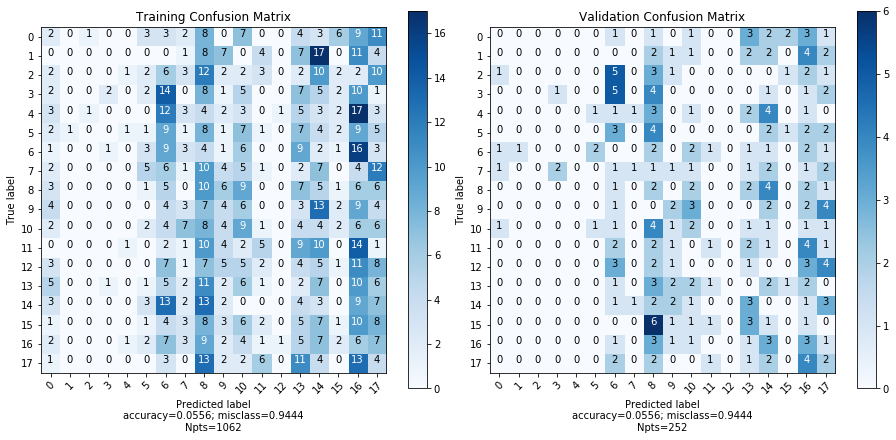

epoch = 100/2516, iteration: 1800/45288, Loss: Training: 1.982046344528226, Validation: 2.1425699013739585
Accuracy: Training: 36.44%, Validation: 32.14%. 
epoch = 200/2516, iteration: 3600/45288, Loss: Training: 1.6972114879469538, Validation: 1.9519035363607586
Accuracy: Training: 46.89%, Validation: 38.49%. 
epoch = 300/2516, iteration: 5400/45288, Loss: Training: 1.4621795852364181, Validation: 1.8784081205645329
Accuracy: Training: 52.35%, Validation: 40.08%. 
epoch = 400/2516, iteration: 7200/45288, Loss: Training: 1.4129162237067363, Validation: 1.8379047800241082
Accuracy: Training: 57.16%, Validation: 44.44%. 
epoch = 500/2516, iteration: 9000/45288, Loss: Training: 1.295517839018132, Validation: 1.8253228138815096
Accuracy: Training: 59.98%, Validation: 44.84%. 
confusion matrix epoch: 500


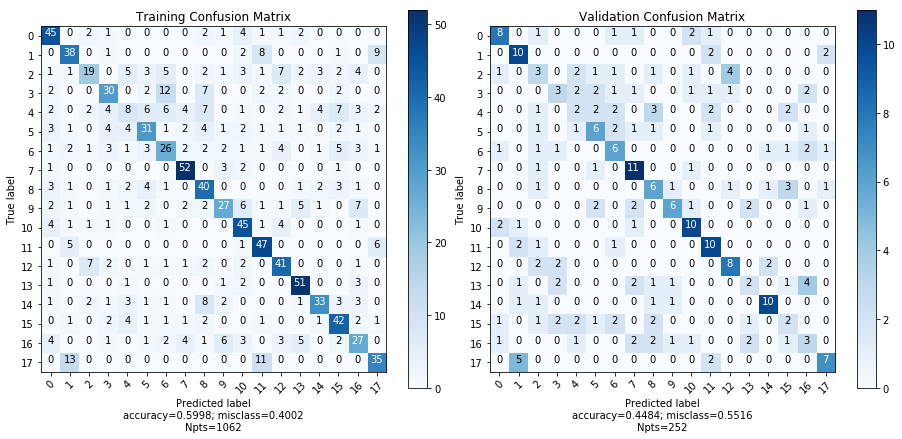

epoch = 600/2516, iteration: 10800/45288, Loss: Training: 1.1911672779437357, Validation: 1.8175948343692596
Accuracy: Training: 61.96%, Validation: 44.84%. 
epoch = 700/2516, iteration: 12600/45288, Loss: Training: 1.1563097767884165, Validation: 1.8205990292857135
Accuracy: Training: 64.41%, Validation: 44.05%. 
epoch = 800/2516, iteration: 14400/45288, Loss: Training: 1.0807760110284619, Validation: 1.819174863140554
Accuracy: Training: 65.73%, Validation: 44.44%. 
epoch = 900/2516, iteration: 16200/45288, Loss: Training: 1.0075824027743199, Validation: 1.8275311818661553
Accuracy: Training: 67.61%, Validation: 45.63%. 
epoch = 1000/2516, iteration: 18000/45288, Loss: Training: 1.0211114897997051, Validation: 1.8378699614144915
Accuracy: Training: 67.61%, Validation: 47.22%. 
confusion matrix epoch: 1000


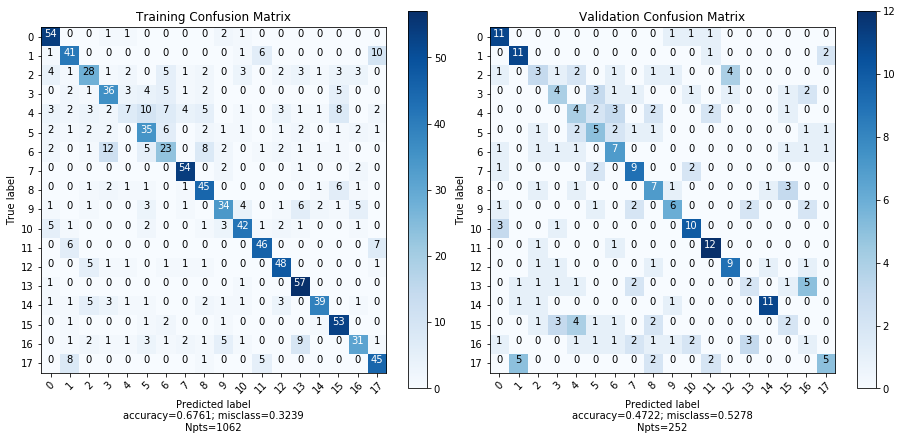

epoch = 1100/2516, iteration: 19800/45288, Loss: Training: 0.9433651378378292, Validation: 1.8514738049079436
Accuracy: Training: 71.0%, Validation: 48.02%. 
epoch = 1200/2516, iteration: 21600/45288, Loss: Training: 0.9183508665513759, Validation: 1.8468054610645264
Accuracy: Training: 71.37%, Validation: 49.21%. 
epoch = 1300/2516, iteration: 23400/45288, Loss: Training: 0.8511585355315108, Validation: 1.8597253013830957
Accuracy: Training: 73.82%, Validation: 48.81%. 
epoch = 1400/2516, iteration: 25200/45288, Loss: Training: 0.8501320455700855, Validation: 1.8781397954234758
Accuracy: Training: 73.82%, Validation: 50.79%. 
epoch = 1500/2516, iteration: 27000/45288, Loss: Training: 0.8426201670387068, Validation: 1.8942350129289458
Accuracy: Training: 75.42%, Validation: 49.6%. 
confusion matrix epoch: 1500


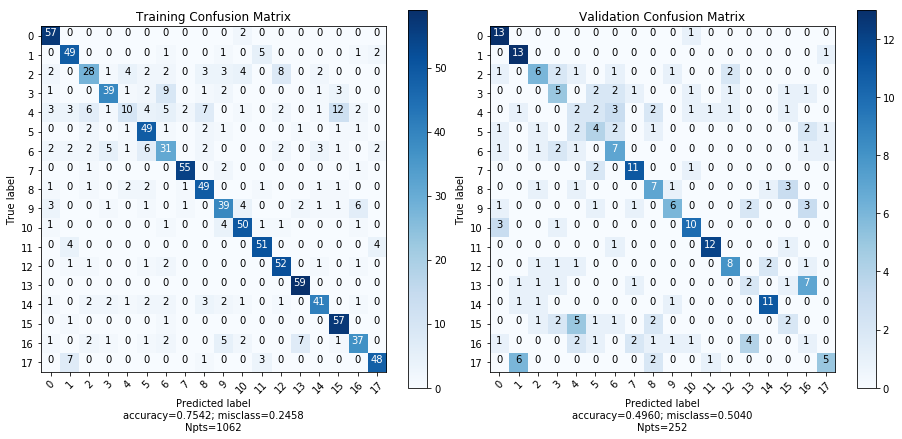

epoch = 1600/2516, iteration: 28800/45288, Loss: Training: 0.8186621994189752, Validation: 1.901963056054961
Accuracy: Training: 75.8%, Validation: 50.4%. 
epoch = 1700/2516, iteration: 30600/45288, Loss: Training: 0.7888944063940457, Validation: 1.919664750608757
Accuracy: Training: 77.5%, Validation: 50.0%. 
epoch = 1800/2516, iteration: 32400/45288, Loss: Training: 0.769627056585371, Validation: 1.9164333967248726
Accuracy: Training: 76.27%, Validation: 50.4%. 
epoch = 1900/2516, iteration: 34200/45288, Loss: Training: 0.7385099496382478, Validation: 1.9538455521163502
Accuracy: Training: 78.53%, Validation: 49.21%. 
epoch = 2000/2516, iteration: 36000/45288, Loss: Training: 0.7510840888601781, Validation: 1.9775838124904663
Accuracy: Training: 78.25%, Validation: 48.81%. 
confusion matrix epoch: 2000


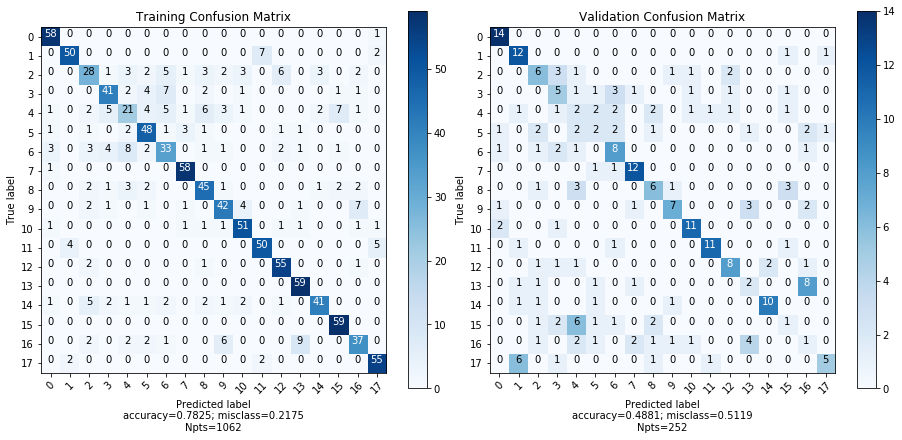

epoch = 2100/2516, iteration: 37800/45288, Loss: Training: 0.7226170881874333, Validation: 2.0060396535225338
Accuracy: Training: 77.78%, Validation: 47.22%. 
epoch = 2200/2516, iteration: 39600/45288, Loss: Training: 0.6966476446413624, Validation: 2.004408831810189
Accuracy: Training: 80.41%, Validation: 47.62%. 
epoch = 2300/2516, iteration: 41400/45288, Loss: Training: 0.7243421494454877, Validation: 2.031529356275342
Accuracy: Training: 79.1%, Validation: 49.21%. 
epoch = 2400/2516, iteration: 43200/45288, Loss: Training: 0.6286403895023159, Validation: 2.0550731108435554
Accuracy: Training: 80.79%, Validation: 48.41%. 
epoch = 2500/2516, iteration: 45000/45288, Loss: Training: 0.6929557090823352, Validation: 2.068310682093462
Accuracy: Training: 79.76%, Validation: 50.4%. 
confusion matrix epoch: 2500


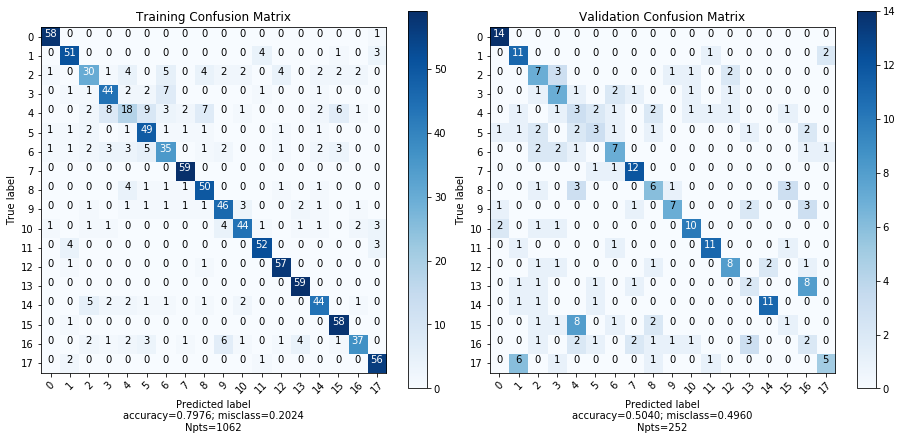

confusion matrix epoch: 2515


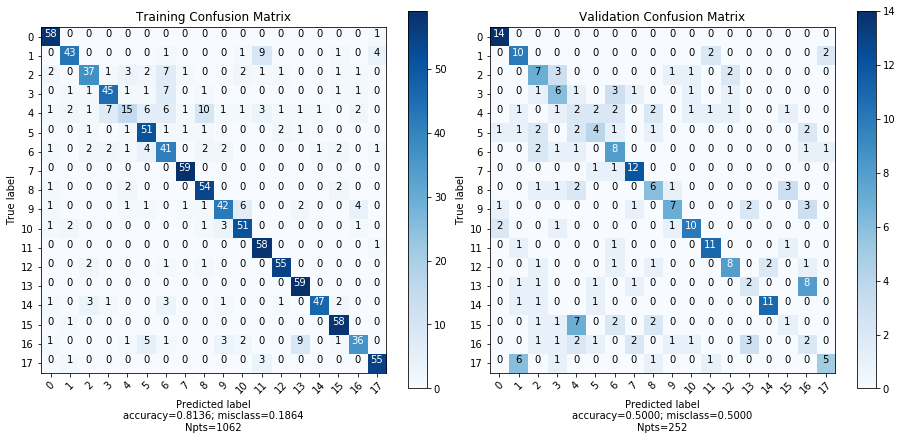

training took 135.22237703402837 minutes


In [45]:
weights_init_a, model_param_a = set_weights_parameters(n_1=20, k_1=5, n_len=max(names_length),
                                                   n_2=20, k_2=3, eta=0.001, rho=.9, 
                                                   batch_size=100,epochs=135, n_updates=197)
network_a = ConvNet(data, model_param_a, weights_init_a)

best_model_a, Results_a = train_model(network_a, shuffle_data = False, balance_data = True,
                                weights_update ='momentum', print_conf_matrix = True, 
                                save_cm = '070819_results_cm_', 
                                save_results_file = '070819_results' )

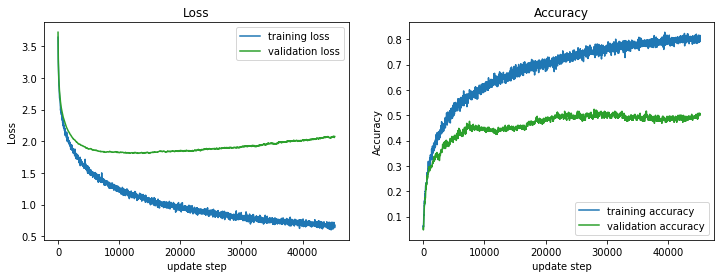

In [55]:
plot_results(Results_a, save_file='loss_acc_070819')

In [247]:
best_model_a['val_acc'] 

0.5238095238095238

In [128]:
print(pd.DataFrame(data=[(round(i * 100,2)) for i in best_model_a['cm_validation'].diagonal()/np.sum(best_model_a['cm_validation'],axis=1)],
                   columns = ['Class Accuracy'], index=list(categ_labels.values())))
print()


            Class Accuracy
Arabic              100.00
Chinese              85.71
Czech                42.86
Dutch                35.71
English              14.29
French               35.71
German               50.00
Greek                85.71
Irish                50.00
Italian              42.86
Japanese             78.57
Korean               85.71
Polish               71.43
Portuguese           14.29
Russian              78.57
Scottish             14.29
Spanish               7.14
Vietnamese           50.00



## Training with unbalanced data:

epochs = 135
epoch = 0/135, iteration: 0/26595, Loss: Training: 4.690513343782435, Validation: 3.94041825045257
Accuracy: Training: 3.35%, Validation: 3.57%. 
confusion matrix epoch: 0


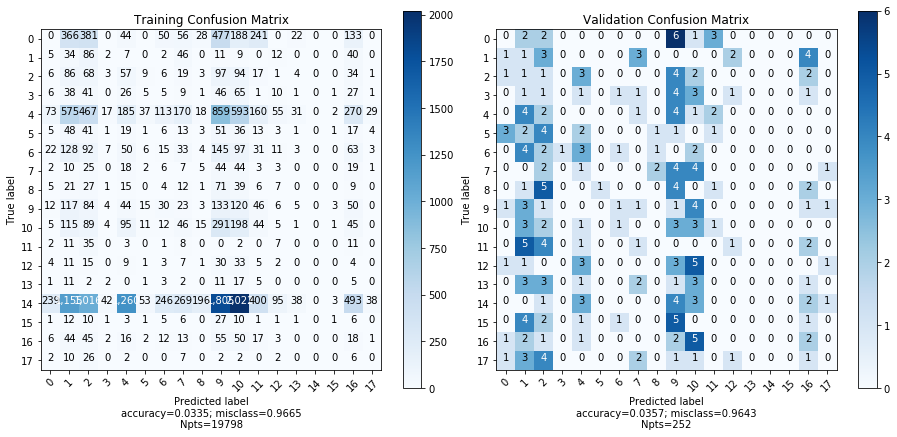

epoch = 15/135, iteration: 2955/26595, Loss: Training: 1.409486110833901, Validation: 3.4845178083315633
Accuracy: Training: 56.2%, Validation: 10.71%. 
epoch = 30/135, iteration: 5910/26595, Loss: Training: 1.203163774286715, Validation: 3.3052863741235696
Accuracy: Training: 63.02%, Validation: 15.87%. 
epoch = 45/135, iteration: 8865/26595, Loss: Training: 1.0884362732905555, Validation: 3.184414538577781
Accuracy: Training: 66.37%, Validation: 18.25%. 
confusion matrix epoch: 55


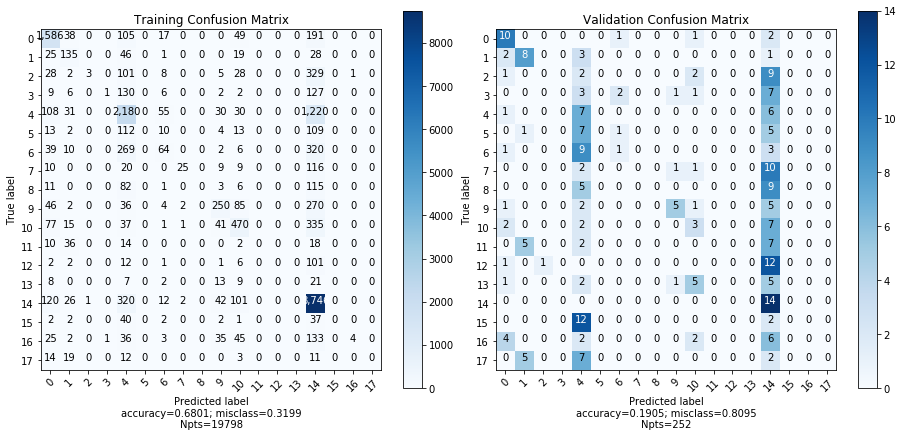

epoch = 60/135, iteration: 11820/26595, Loss: Training: 1.0128193065364248, Validation: 3.0916286826938912
Accuracy: Training: 68.69%, Validation: 19.44%. 
epoch = 75/135, iteration: 14775/26595, Loss: Training: 0.9556888762395768, Validation: 3.0146216163093675
Accuracy: Training: 70.93%, Validation: 21.83%. 
epoch = 90/135, iteration: 17730/26595, Loss: Training: 0.9116297852900338, Validation: 2.9543342951911855
Accuracy: Training: 72.27%, Validation: 25.0%. 
epoch = 105/135, iteration: 20685/26595, Loss: Training: 0.8758262312912348, Validation: 2.906025094775374
Accuracy: Training: 73.42%, Validation: 26.59%. 
confusion matrix epoch: 110


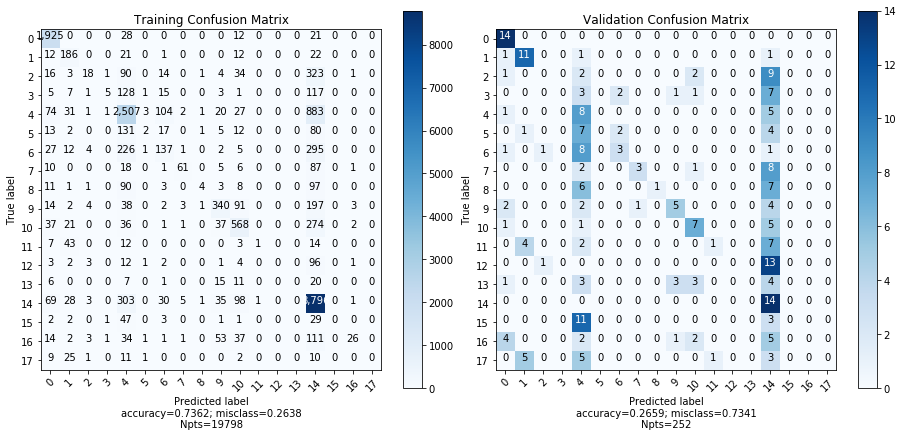

epoch = 120/135, iteration: 23640/26595, Loss: Training: 0.8463588676382053, Validation: 2.864713733862808
Accuracy: Training: 74.09%, Validation: 26.59%. 
confusion matrix epoch: 134


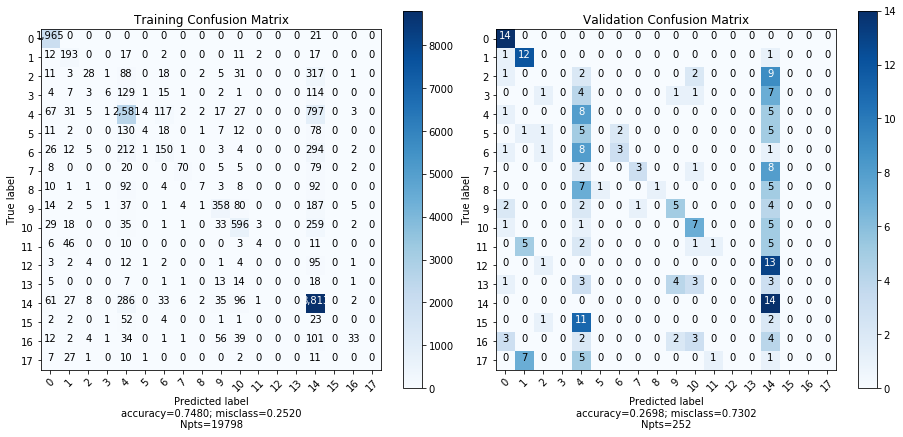

training took 163.12354506651562 minutes


In [133]:
weights_init_b, model_param_b = set_weights_parameters(n_1=20, k_1=5, n_len=max(names_length),
                                                   n_2=20, k_2=3, eta=0.001, rho=.9, 
                                                   batch_size=100,epochs=135, n_updates=197)
network_b = ConvNet(data, model_param_b, weights_init_b)

best_model_b, Results_b = train_model(network_b, shuffle_data = False, balance_data = False,
                                weights_update ='momentum', print_conf_matrix = True, 
                                save_cm = '070819_results_cm_b', 
                                save_results_file = '070819_resultsb',
                                      update_epoch = 15, update_cm = 55)

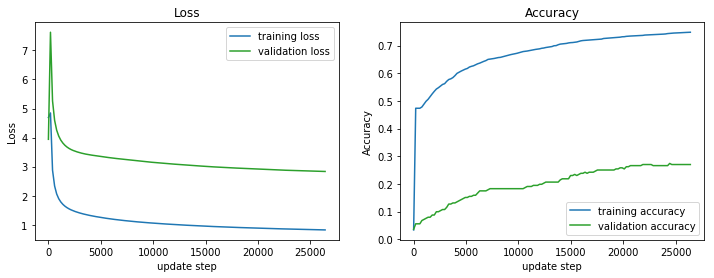

In [135]:
plot_results(Results_b, save_file='loss_acc_080819')

# Best model predictions:

In [103]:
test_data = ['Herrera', 'Nguyen','Souza', 'Vilanova', 'De Fenza', 'Claramunt']
test_data_vectorized = vectorize_input(test_data, d, n_len, char_to_int)

In [72]:
network_test_names = ConvNet(data, model_param_a, weights_init_a)

In [73]:
network_test_names.W = best_model_a['W']
network_test_names.F[0] = best_model_a['F'][0]
network_test_names.F[1] = best_model_a['F'][1]

In [104]:
vectorized_batch_X, p_batch, p_argmax, _ = ForwardPass(network_test_names, test_data_vectorized)

In [105]:
for idx ,y_pred in enumerate(p_argmax):
    print(test_data[idx]+": "+list(categ_labels.values())[y_pred])

Herrera: Spanish
Nguyen: Vietnamese
Souza: Portuguese
Vilanova: Spanish
De Fenza: Italian
Claramunt: French


In [130]:
print(pd.DataFrame(data=p_batch, columns=test_data, index=list(categ_labels.values())))

                 Herrera        Nguyen         Souza      Vilanova  \
Arabic      3.093289e-08  1.499237e-07  1.721060e-02  6.485411e-15   
Chinese     9.114853e-14  3.429574e-10  1.713460e-05  1.846621e-12   
Czech       5.370408e-02  1.145396e-03  3.131045e-03  1.838381e-01   
Dutch       6.775194e-02  3.002357e-05  7.659580e-05  6.107547e-07   
English     1.036293e-01  9.436270e-03  1.118542e-03  3.830459e-04   
French      7.300662e-03  4.860623e-03  6.374191e-04  1.000220e-07   
German      1.539253e-02  2.298919e-03  1.426632e-04  4.195616e-07   
Greek       3.289555e-04  1.806693e-07  2.898944e-05  9.922694e-04   
Irish       7.088942e-03  4.951051e-03  1.805337e-04  3.728561e-05   
Italian     5.373391e-02  3.782137e-04  2.231220e-02  1.270127e-01   
Japanese    1.116729e-05  1.850894e-06  6.160325e-02  1.811190e-03   
Korean      3.111754e-10  1.052336e-09  4.189149e-10  3.304993e-18   
Polish      2.192972e-04  1.999560e-06  1.950744e-03  1.028205e-05   
Portuguese  4.616457

# Efficiency gains: sparse matrix for first layer

In [257]:
#Training with sparse matrix in first layer:

weights_init_c, model_param_c = set_weights_parameters(n_1=5, k_1=5, n_len=max(names_length),
                                                   n_2=5, k_2=5, eta=0.001, rho=.9, 
                                                   batch_size=100,epochs=5, n_updates=197)
network_c = ConvNet(data, model_param_c, weights_init_c)

best_model_c, Results_c = train_model(network_c, shuffle_data = False, balance_data = False,
                                weights_update ='momentum', print_conf_matrix = False, Verbose=False,
                                save_cm = 'none', 
                                save_results_file = 'none' )

epochs = 5
training took 0.4750783324241638 minutes


In [261]:
#Training without sparse matrix in first layer: 

weights_init_d, model_param_d = set_weights_parameters(n_1=5, k_1=5, n_len=max(names_length),
                                                   n_2=5, k_2=5, eta=0.001, rho=.9, 
                                                   batch_size=100,epochs=5, n_updates=197)
network_d = ConvNet(data, model_param_c, weights_init_c)

best_model_d, Results_d = train_model(network_c, shuffle_data = False, balance_data = False,
                                weights_update ='momentum', print_conf_matrix = False, Verbose=False,
                                save_cm = 'none', 
                                save_results_file = 'none' )

epochs = 5
training took 0.6272456208864848 minutes
